# Tutorial 21: Sparse Modes with with heat example <br>
<br>
Tutorial 21: Use Sparse Mode DMD (SMDMD) to enforce boundary constraints while performing rank reduction.<br>
This tutorial is similar to Tutorial 9 for using Sparse DMD (SpDMD).
Sparsifying the modes has the same effect as pruning amplitudes.

In [5]:
import logging
import os

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
from pydmd import DMD, SMDMD
from pydmd.dmd_modes_tuner import BOUND

/workspaces/PyDMD/pydmd/snapshots.py:73: UserWarning: Input data condition number 5.627258333992611e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
[snapshots.py:36 -             __init__() ] Snapshots: (441, 100), snapshot shape: (441,)
[snapshots.py:36 -             __init__() ] Snapshots: (441, 100), snapshot shape: (441,)
[snapshots.py:36 -             __init__() ] Snapshots: (441, 100), snapshot shape: (441,)
[snapshots.py:36 -             __init__() ] Snapshots: (441, 100), snapshot shape: (441,)
[snapshots.py:36 -             __init__() ] Snapshots: (441, 100), snapshot shape: (441,)
[snapshots.py:36 -             __init__() ] Snapshots: (441, 100), snapshot shape: (441,)
[snapshots.py:36 -             __init__() ] Snapshots: (441, 100), snapshot shape: (441,)
[snapshots.py:36 -             __init__() ] Snapshots: (441, 100), snapshot shape: (441,)
[1196366949.py:33 -             <module>() ] beta=1e-15 - mean error

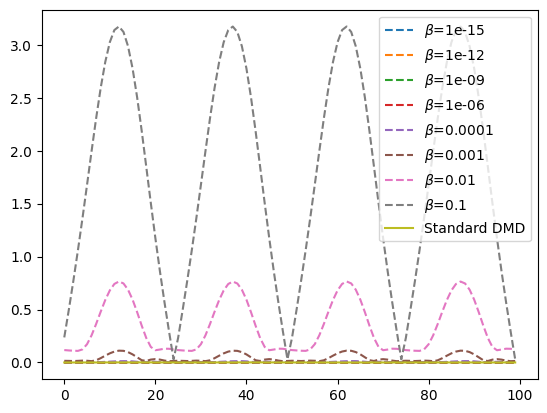

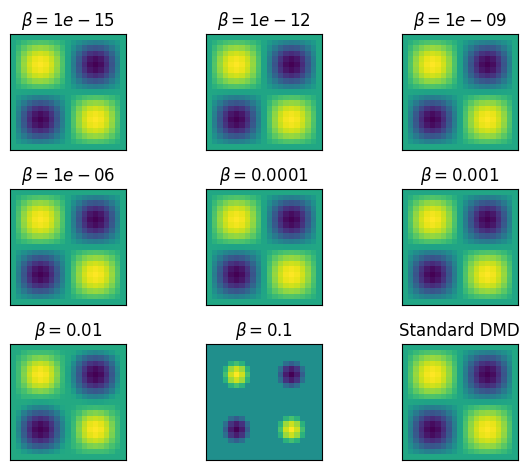

In [8]:
if __name__ == "__main__":
    logging.getLogger().setLevel(logging.INFO)
    DIR = os.path.dirname(os.path.abspath(""))
    DIR = os.path.join(DIR, "data")
    DATA = os.path.join(DIR, "heat_90.npy")
    X = np.load(DATA)
    rb = BOUND(X.min(), X.max())
    ib = BOUND(-np.inf, np.inf)
    osqp_settings = {
        "linsys_solver": "qdldl",
        "max_iter": int(1e6),
        "verbose": False,
        "polish": True,
    }
    betas = [1e-15, 1e-12, 1e-9, 1e-6, 1e-4, 1e-3, 1e-2, 0.1]
    res = [
        SMDMD(
            svd_rank=30,
            alpha=1.0,
            beta=beta,
            rb=rb,
            ib=ib,
            qp_max_iter=10,
            osqp_settings=osqp_settings,
        ).fit(X)
        for beta in betas
    ]
    fig1, ax1 = plt.subplots(1, 1)
    for i, dmd in enumerate(res):
        time = dmd.dmd_timesteps
        error = np.linalg.norm(X - dmd.reconstructed_data, axis=0)
        ax1.plot(time, error, "--", label=rf"$\beta$={betas[i]}")
        logging.info(f"beta={betas[i]} - mean error: {error.mean()}")
    dmd = DMD(svd_rank=30)
    dmd.fit(X)
    error = np.linalg.norm(X - dmd.reconstructed_data, axis=0)
    logging.info(f"Standard DMD mean error: {error.mean()}")
    ax1.plot(dmd.dmd_timesteps, error, label="Standard DMD")
    ax1.legend()
    fig2, ax2 = plt.subplots(3, 3)
    ax2_flat = np.ravel(ax2)
    for i, r in enumerate(res):
        ax2_flat[i].imshow(
            r.reconstructed_data[:, 2].real.reshape(21, 21), cmap="viridis"
        )
        ax2_flat[i].set_xticks([])
        ax2_flat[i].set_yticks([])
        ax2_flat[i].set_title(rf"$\beta={betas[i]}$")
    ax2_flat[-1].imshow(
        dmd.reconstructed_data[:, 2].real.reshape(21, 21), cmap="viridis"
    )
    ax2_flat[-1].set_xticks([])
    ax2_flat[-1].set_yticks([])
    ax2_flat[-1].set_title("Standard DMD")
    fig2.tight_layout()
    plt.show()